# Notebook 4 - GradientBoosting

Random Forest has clearly demonstrated its ability to:

- Capture non-linear interactions between variables (moneyness, maturity, implied volatility).

- Significantly reduce the overall average error compared to the linear model.

- Eliminate a large portion of the biases.

However, the model struggles to capture the strong local convexity of the price around the ATM zone. This is what motivates the use of XGBoost.

In this Notebook:
- Try to improve ATM zone
- Analysing differencies with Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_STATE = 42
data_path = "../notebooks/data/processed/aapl_calls_ml_dataset.csv"
df = pd.read_csv(data_path, parse_dates=["QUOTE_DATE", "EXPIRE_DATE"])

# TARGET + FEATURES:
features = ["log_moneyness", "T_years", "C_IV"]
features = [f for f in features if f in df.columns]
greeks = ["C_DELTA", "C_GAMMA", "C_VEGA", "C_THETA", "C_RHO"]
greeks = [g for g in greeks if g in df.columns]

df = df.sort_values("QUOTE_DATE").copy()
y = (df["TARGET_PRICE"] / df["S"]).copy()
X = df[features].copy()  

# TRAIN/TEST SPLIT (time-based):
split_date = pd.Timestamp("2023-01-01")
train_mask = df["QUOTE_DATE"] < split_date
test_mask  = df["QUOTE_DATE"] >= split_date

X_train = X.loc[train_mask]
y_train = y.loc[train_mask]
X_test  = X.loc[test_mask]
y_test  = y.loc[test_mask]

# CHECKS:
assert X_train.index.equals(y_train.index)
assert X_test.index.equals(y_test.index)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train dates:", df.loc[train_mask, "QUOTE_DATE"].min(), "->", df.loc[train_mask, "QUOTE_DATE"].max())
print("Test dates:",  df.loc[test_mask,  "QUOTE_DATE"].min(), "->", df.loc[test_mask,  "QUOTE_DATE"].max())


Train: (416329, 3)  Test: (60938, 3)
Train dates: 2021-01-04 00:00:00 -> 2022-12-30 00:00:00
Test dates: 2023-01-03 00:00:00 -> 2023-03-31 00:00:00


## GradientBoosting

Naive method

In [3]:
y_pred_naive = np.full(shape=len(y_test), fill_value=y_train.mean())

rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))
mae_naive = mean_absolute_error(y_test, y_pred_naive)
print(f"Naive baseline | RMSE={rmse_naive:.6f} | MAE={mae_naive:.6f}")


Naive baseline | RMSE=0.186982 | MAE=0.161454


In [4]:
gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    n_estimators=600,
    max_depth=3,
    min_samples_leaf=50,
    min_samples_split=100,
    subsample=0.8,
    random_state=RANDOM_STATE
)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"GBR | RMSE={rmse:.6f} | MAE={mae:.6f} | R2={r2:.6f}")

GBR | RMSE=0.009435 | MAE=0.005972 | R2=0.997320


In [5]:
price_true = y_test * df.loc[test_mask, "S"].values
price_pred = y_pred * df.loc[test_mask, "S"].values

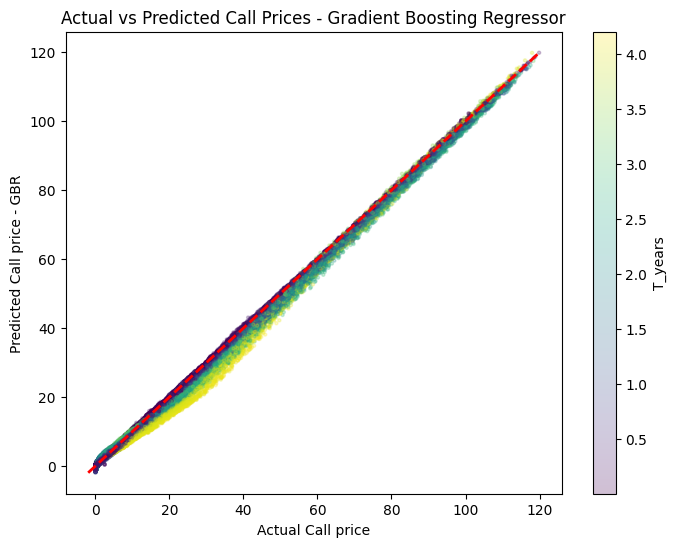

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(price_true, price_pred,c=X_test["T_years"], s=5, alpha=0.25)
lims = [min(price_true.min(), price_pred.min()), max(price_true.max(), price_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=2)
plt.xlabel("Actual Call price")
plt.ylabel("Predicted Call price - GBR")
plt.title("Actual vs Predicted Call Prices - Gradient Boosting Regressor")
plt.colorbar(label="T_years")
plt.show()

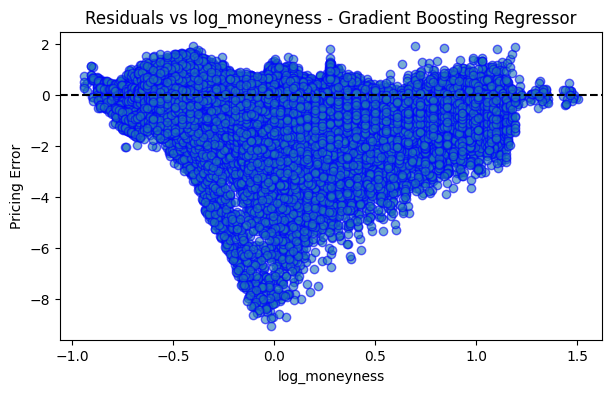

In [9]:
residuals = price_pred - price_true 
log_m=df.loc[test_mask, "log_moneyness"].values

plt.figure(figsize=(7,4))
plt.scatter(log_m, residuals, edgecolors="blue", alpha=0.6)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("log_moneyness")
plt.ylabel("Pricing Error")
plt.title("Residuals vs log_moneyness - Gradient Boosting Regressor")
plt.show()


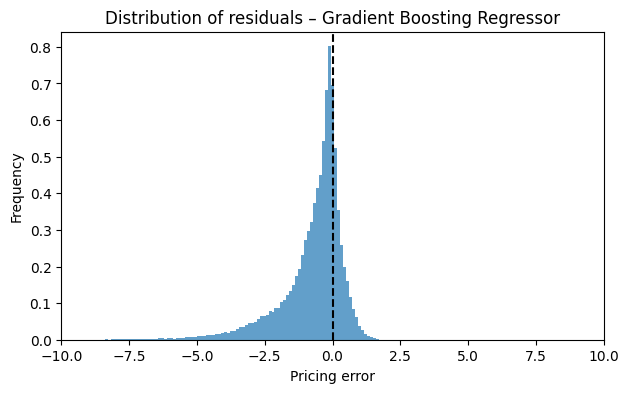

In [10]:
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=100, density=True, alpha=0.7)
plt.axvline(0, linestyle="--", color="black")
plt.xlim(-10, 10)
plt.title("Distribution of residuals – Gradient Boosting Regressor")
plt.xlabel("Pricing error")
plt.ylabel("Frequency")
plt.show()